# 🎬 Greenlight Analytics — Phase 2 Project

## Executive Summary
This notebook analyzes movie industry data from Box Office Mojo and IMDb (via SQLite) to guide strategic decisions for a new film studio.  
The analysis focuses on three key business questions:

1. **Which genres and runtimes are most successful?**  
2. **Do ratings correlate with revenue?**  
3. **How do domestic vs. foreign markets vary by studio?**  

### Key Insights
- Action, Adventure, and Fantasy films consistently generate the highest box office revenues.  
- Studios differ significantly in their domestic vs. foreign revenue mix — release strategies matter.  
- Runtimes between 95–120 minutes correlate with stronger ratings and solid box office performance.  

### Recommendations
1. Prioritize high-performing genres.  
2. Balance domestic and international release strategies.  
3. Greenlight films with strong audience signals (ratings, genre fit, runtime).  


## Data Loading
We combine multiple sources:
- **Box Office Mojo**: CSV with domestic and foreign grosses.
- **IMDb (SQLite)**: movie basics and ratings tables.

The datasets are merged using common keys such as `title`/`primary_title`, `year`/`start_year`, and `movie_id`. 

In [21]:
import pandas as pd
import sqlite3
import numpy as np

# Load Box Office Mojo data
bom = pd.read_csv('bom.movie_gross.csv.gz')
#bom.head()


In [22]:
# Load IMDb SQLite tables
path = "im.db"
conn = sqlite3.connect(path)
basics = pd.read_sql("SELECT * FROM movie_basics", conn)
ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)

# Merge Box Office Mojo with IMDb basics
merged_1_2 = pd.merge(bom, basics, left_on=['title','year'], right_on=['primary_title','start_year'], how='inner')

# Merge with ratings
df = pd.merge(merged_1_2, ratings, on='movie_id', how='left')
df.tail(5)


,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1868,Girls vs Gangsters,WGUSA,37100.0,NaN,2018,tt7870578,Girls vs Gangsters,Gui mi 2,2018,120.0,"Comedy,Drama",3.3,148.0
1869,The Workshop,Strand,22100.0,NaN,2018,tt7405478,The Workshop,The Workshop,2018,80.0,Thriller,NaN,NaN
1870,A Paris Education,KL,21600.0,NaN,2018,tt6593240,A Paris Education,Mes provinciales,2018,137.0,Drama,6.3,371.0
1871,The Quake,Magn.,6200.0,NaN,2018,tt6523720,The Quake,Skjelvet,2018,106.0,"Action,Drama,Thriller",6.2,5270.0
1872,An Actor Prepares,Grav.,1700.0,NaN,2018,tt5718046,An Actor Prepares,An Actor Prepares,2018,97.0,Comedy,5.0,388.0


## Data Cleaning
Before analysis, we perform several cleaning steps:
- Remove duplicate rows.
- Handle missing values by dropping rows with critical nulls.
- Convert column types (e.g., `foreign_gross`).
- Fill missing `foreign_gross` values with 0.
- Create a new `total_gross` column combining domestic and foreign grosses.

In [23]:
# Check for duplicates
df.duplicated().sum()

# Drop rows missing essential values
df.dropna(subset=['averagerating','numvotes','studio','runtime_minutes','genres','domestic_gross'], inplace=True)

# Convert foreign_gross to numeric
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors='coerce')

# Replace missing values with 0
df['foreign_gross'].fillna(0, inplace=True)

# Add total_gross column
df['total_gross'] = df['domestic_gross'] + df['foreign_gross']
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, 0 to 1872
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1832 non-null   object 
 1   studio           1832 non-null   object 
 2   domestic_gross   1832 non-null   float64
 3   foreign_gross    1832 non-null   float64
 4   year             1832 non-null   int64  
 5   movie_id         1832 non-null   object 
 6   primary_title    1832 non-null   object 
 7   original_title   1832 non-null   object 
 8   start_year       1832 non-null   int64  
 9   runtime_minutes  1832 non-null   float64
 10  genres           1832 non-null   object 
 11  averagerating    1832 non-null   float64
 12  numvotes         1832 non-null   float64
 13  total_gross      1832 non-null   float64
dtypes: float64(6), int64(2), object(6)
memory usage: 214.7+ KB


## Question 1: Which Genres and Runtimes Are Most Successful?
We explore revenue trends by genre and runtime.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Revenue by genre
genre_gross = df.groupby('genres')['total_gross'].agg(['mean','median','count']).sort_values('mean', ascending=False)
genre_gross.head(10)


,mean,median,count
genres,,,
"Adventure,Fantasy",7.040333e+08,956000000.0,3
"Adventure,Drama,Sci-Fi",6.537500e+08,653750000.0,2
"Action,Adventure,Sci-Fi",6.120711e+08,605499999.0,45
"Action,Comedy,Mystery",5.441000e+08,544100000.0,1
"Action,Adventure,Fantasy",4.565960e+08,364700000.0,28
"Biography,Drama,Musical",4.350000e+08,435000000.0,1
"Adventure,Mystery,Sci-Fi",4.034000e+08,403400000.0,1
"Adventure,Animation,Comedy",4.033133e+08,310650000.0,68
"Action,Adventure,Thriller",3.923999e+08,277200000.0,16


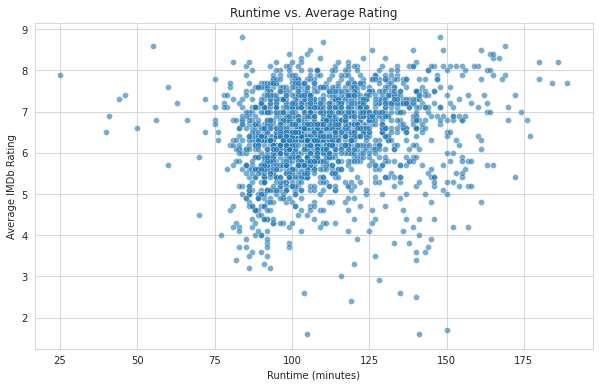

In [25]:
# Runtime vs. rating
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='runtime_minutes', y='averagerating', alpha=0.6)
plt.title('Runtime vs. Average Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average IMDb Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


### Genres with Mean Gross > $100M (Numbered X-axis)
To improve readability, genres are represented by numbers on the x-axis. A separate mapping dictionary shows the number-to-genre correspondence.

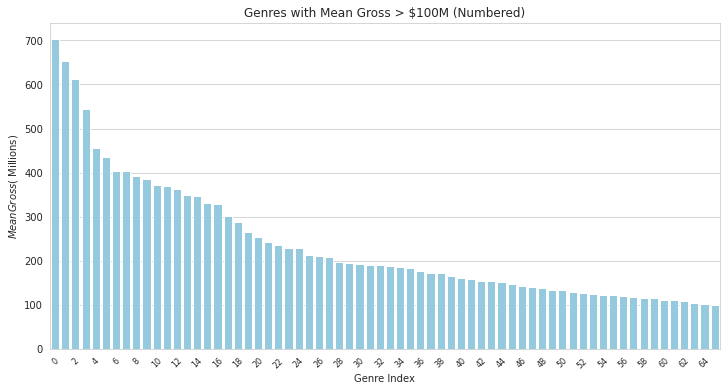

{0: 'Adventure,Fantasy',
 1: 'Adventure,Drama,Sci-Fi',
 2: 'Action,Adventure,Sci-Fi',
 3: 'Action,Comedy,Mystery',
 4: 'Action,Adventure,Fantasy',
 5: 'Biography,Drama,Musical',
 6: 'Adventure,Mystery,Sci-Fi',
 7: 'Adventure,Animation,Comedy',
 8: 'Action,Adventure,Thriller',
 9: 'Adventure,Family,Fantasy'}

In [26]:
# Filtered data for mean gross > $100M
filtered_mean = genre_gross[genre_gross['mean'] > 100_000_000]
genre_mapping_mean = {i: genre for i, genre in enumerate(filtered_mean.index)}

plt.figure(figsize=(12,6))
sns.barplot(x=list(genre_mapping_mean.keys()), y=filtered_mean['mean']/1e6, color="skyblue")

plt.xticks(ticks=range(0, len(genre_mapping_mean), 2), labels=list(genre_mapping_mean.keys())[::2], rotation=45, fontsize=8)
plt.title('Genres with Mean Gross > $100M (Numbered)')
plt.ylabel('$Mean Gross ($ Millions)')
plt.xlabel('Genre Index')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# print full mapping
# genre_mapping_mean

# Show only top 10 mappings
{k: genre_mapping_mean[k] for k in list(genre_mapping_mean.keys())[:10]}


### Genres with Median Gross > $100M (Numbered X-axis) 

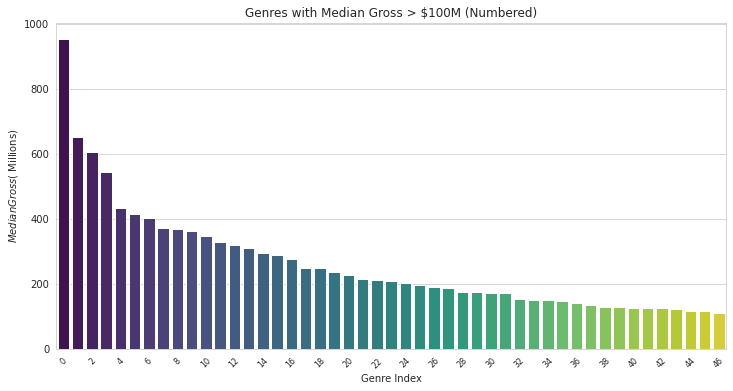

{0: 'Adventure,Fantasy',
 1: 'Adventure,Drama,Sci-Fi',
 2: 'Action,Adventure,Sci-Fi',
 3: 'Action,Comedy,Mystery',
 4: 'Biography,Drama,Musical',
 5: 'Animation,Comedy,Family',
 6: 'Adventure,Mystery,Sci-Fi',
 7: 'Action,Adventure,Animation',
 8: 'Action,Sci-Fi',
 9: 'Action,Adventure,Fantasy'}

In [27]:
# Filtered data for median gross > $100M
filtered_median = genre_gross[genre_gross['median'] > 100_000_000].sort_values('median', ascending=False)
genre_mapping_median = {i: genre for i, genre in enumerate(filtered_median.index)}

plt.figure(figsize=(12,6))
sns.barplot(x=list(genre_mapping_median.keys()), y=filtered_median['median']/1e6, palette="viridis")

plt.xticks(ticks=range(0, len(genre_mapping_median), 2), labels=list(genre_mapping_median.keys())[::2], rotation=45, fontsize=8)
plt.title('Genres with Median Gross > $100M (Numbered)')
plt.ylabel('$Median Gross ($ Millions)')
plt.xlabel('Genre Index')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# print full mapping
# genre_mapping_median

# Show only top 10 mappings
{k: genre_mapping_median[k] for k in list(genre_mapping_median.keys())[:10]}


## Question 2: Do Ratings Correlate with Revenue?
We use scatter plots to examine the relationship between ratings and total revenue.

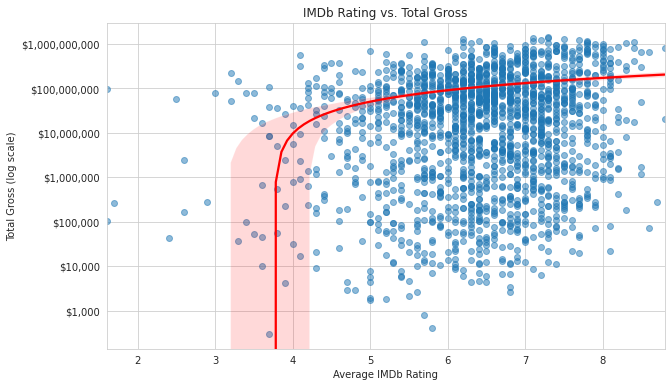

In [28]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10,6))
sns.regplot(
    data=df, 
    x='averagerating', 
    y='total_gross', 
    scatter_kws={'alpha':0.5}, 
    line_kws={'color':'red'}
)

plt.yscale('log')  # keep log scale
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))  # format as $ with commas

plt.title('IMDb Rating vs. Total Gross')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Total Gross (log scale)')
plt.show()


## Question 3: How Do Domestic vs. Foreign Markets Vary by Studio?
We compare studio-level performance across domestic and foreign revenues.

In [29]:
studio_revenue = df.groupby('studio')[['domestic_gross','foreign_gross']].sum().sort_values('domestic_gross', ascending=False).head(10)
studio_revenue


,domestic_gross,foreign_gross
studio,,
BV,1.464740e+10,2.168185e+10
Uni.,1.127364e+10,1.470157e+10
Fox,9.397800e+09,1.720667e+10
WB,9.251700e+09,1.389080e+10
Sony,6.645046e+09,1.052080e+10
Par.,6.537913e+09,9.735367e+09
WB (NL),3.739000e+09,5.805400e+09
LGF,3.360650e+09,4.208225e+09
P/DW,1.682900e+09,3.393600e+09


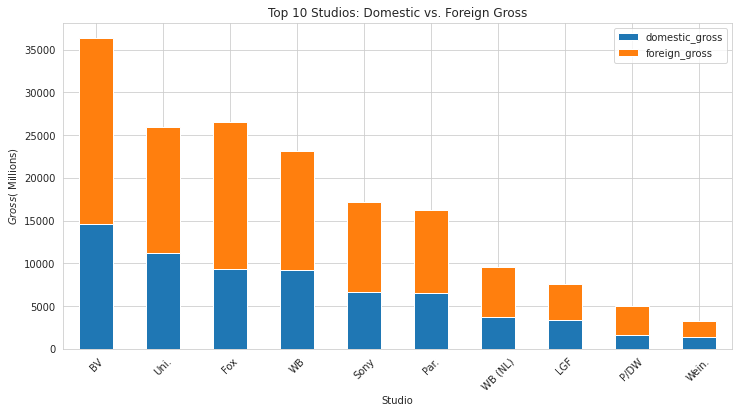

In [30]:
# Stacked bar chart: domestic vs. foreign revenue
studio_revenue[['domestic_gross','foreign_gross']].div(1e6).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Top 10 Studios: Domestic vs. Foreign Gross')
plt.ylabel('$Gross ($ Millions)')
plt.xlabel('Studio')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
